In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import seaborn as sns

import simplejson
import json
import math
save = False

# 1. Data Preprocessing

In [2]:
%%time
### Get stock related data ###

if not save:
    stock_info_list = pd.read_feather('stock_list.ftr')
else:
    stock_info_list = pd.read_csv('raw/stock_list.csv', parse_dates=['list_date', 'setup_date'])
    stock_info_list.ts_code = stock_info_list.ts_code.apply(lambda x: x[:6])
    stock_info_list = stock_info_list.query('market == "主板" or market == "中小板"')  # Focus only on mainboard and sme, cover all three-level sectors
    stock_info_list = stock_info_list.query('list_date < "2020-01-01"').reset_index(drop=True)  # Remove those got listed too late (171 of them)
    stock_info_list.to_feather('stock_list.ftr')

if not save:
    trade_cal = pd.read_feather('trade_cal.ftr')
else:
    trade_cal = pd.read_csv('raw/trade_cal.csv', parse_dates=['cal_date'])
    trade_cal.to_feather('trade_cal.ftr')

if not save:
    stock_daily = pd.read_feather('stock_daily.ftr')
    stock_daily_log = pd.read_pickle('stock_daily_log.pkl')
else:
    stock_daily = pd.read_feather('raw/stock_price_post_adjusted.ftr')
    stock_daily.ts_code = stock_daily.ts_code.apply(lambda x: x[:6])
    stock_daily = stock_daily[['ts_code', 'trade_date', 'close', 'vol']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    stock_daily = stock_daily.merge(stock_info_list['ts_code'])
    stock_daily_log = stock_daily.pivot_table(values=['close', 'vol'], index='trade_date', columns='ts_code')
    stock_daily_log = np.log(stock_daily_log)
    stock_daily_log = stock_daily_log - stock_daily_log.shift(1)
    
    stock_daily = stock_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    stock_daily.to_feather('stock_daily.ftr')
    stock_daily_log = stock_daily_log.loc['2011-01-01':]
    stock_daily_log.to_pickle('stock_daily_log.pkl')

CPU times: user 311 ms, sys: 249 ms, total: 560 ms
Wall time: 354 ms


In [3]:
%%time
### Get concept and index related data ###

if not save:
    concept_list = pd.read_feather('concept_list.ftr')
    concept_daily = pd.read_feather('concept_daily.ftr')
    concept_daily_log = pd.read_pickle('concept_daily_log.pkl')
else:
    concept_list = pd.read_csv('raw/concept_member_list.csv').drop('name', axis=1).merge(pd.read_csv('raw/concept_list.csv').drop('list_date', axis=1))
    concept_list.columns = ['concept_code', 'ts_code', 'name']
    concept_list.ts_code = concept_list.ts_code.apply(lambda x: x[:6])
    concept_list = concept_list.merge(stock_info_list['ts_code'])
    concept_list.to_feather('concept_list.ftr')
    
    concept_daily = pd.read_csv('raw/concept_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    concept_daily.columns = ['concept_id', 'trade_date', 'close']
    concept_daily_log = concept_daily.pivot_table(values=['close'], index='trade_date', columns='concept_id')
    concept_daily_log = np.log(concept_daily_log)
    concept_daily_log = concept_daily_log - concept_daily_log.shift(1)
    
    concept_daily = concept_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    concept_daily.to_feather('concept_daily.ftr')
    concept_daily_log = concept_daily_log.close.loc['2011-01-01':]
    concept_daily_log.to_pickle('concept_daily_log.pkl')

    
if not save:
    index_daily = pd.read_feather('index_daily.ftr')
    index_daily_log = pd.read_pickle('index_daily_log.pkl')
else:
    index_daily = pd.read_csv('raw/index_daily_list.csv', parse_dates=['trade_date'])[['ts_code', 'trade_date', 'close']].query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily.columns = ['in_code', 'trade_date', 'close']
    missing_index_daily = [index_daily]
    for missing_index in ['000988', '000994', '000995']:
        missing_index_df = pd.read_json(f'raw/{missing_index}.json', convert_dates='tradedate')
        missing_index_df['in_code'] = f'{missing_index}.SH'
        missing_index_df['trade_date'] = pd.to_datetime(missing_index_df.tradedate)
        missing_index_df.columns = ['1', '2', 'close', '3', '4', 'in_code', 'trade_date']
        missing_index_daily.append(missing_index_df[['in_code', 'trade_date', 'close']])
    index_daily = pd.concat(missing_index_daily).query('"2010-12-25" <= trade_date <= "2020-12-31"')
    index_daily = index_daily.drop_duplicates(['in_code', 'trade_date'])
    index_daily_log = index_daily.pivot_table(values=['close'], index='trade_date', columns='in_code')
    index_daily_log = np.log(index_daily_log)
    index_daily_log = index_daily_log - index_daily_log.shift(1)
    
    index_daily = index_daily.query('"2011-01-01" <= trade_date <= "2020-12-31"').reset_index(drop=True)
    index_daily.to_feather('index_daily.ftr')
    index_daily_log = index_daily_log.close.loc['2011-01-01':]
    index_daily_log.to_pickle('index_daily_log.pkl')

CPU times: user 25.3 ms, sys: 17.2 ms, total: 42.5 ms
Wall time: 29.6 ms


In [4]:
%%time
### Get industry and industry-index related data ###

if not save:
    industry_list = pd.read_feather('industry_list.ftr')
else:
    industry_list = pd.read_csv('raw/industry_member_list.csv').rename(columns={'con_code': 'ts_code'})
    industry_list.ts_code = industry_list.ts_code.apply(lambda x: x[:6])
    industry_list = industry_list.merge(stock_info_list[['ts_code']])
    industry_list = industry_list.merge(pd.read_csv('raw/industry_list.csv'))
    industry_list = industry_list[['industry_code', 'industry_name', 'level', 'ts_code']]
    industry_list.to_feather('industry_list.ftr')

if not save:
    index_industry_list = pd.read_feather('index_industry_list.ftr')
else:
    index_industry_list = pd.read_csv('raw/index_industry_list.csv')[['ts_code', 'name', 'industry_code']]
    index_industry_list.columns = ['in_code', 'name_c', 'industry_code']
    index_name_input = pd.Series({
        '000986.SH': 'Energy',
        '000987.SH': 'Materials',
        '000988.SH': 'Industrials',
        '000989.SH': 'Consumer Discretionary',
        '000990.SH': 'Consumer Staples',
        '000991.SH': 'HealthCare',
        '000992.SH': 'Financials',
        '000993.SH': 'IT',
        '000994.SH': 'Telecom',
        '000995.SH': 'Utilities',
    }, name='name')
    index_industry_list = index_industry_list.merge(index_name_input, left_on='in_code', right_index=True)
    index_industry_list.to_feather('index_industry_list.ftr')

CPU times: user 5.83 ms, sys: 3.99 ms, total: 9.82 ms
Wall time: 7.22 ms


# 2. Correlation networks

In [6]:
%%time

corr_all_years = []

if not save:
    corr_all_years = pd.read_pickle('corr_all_years.pkl')
if save:
    # Takes 15 mins to run
    for year in range(11, 21):
        trade_days = int(trade_cal.query(f'"20{year}-01-01" <= cal_date <= "20{year}-12-31"')['is_open'].sum() * 0.8)
        asset_prices = pd.concat([index_daily_log.loc[f'20{year}-01-01':f'20{year}-12-31']['000001.SH'], stock_daily_log.close.loc[f'20{year}-01-01':f'20{year}-12-31']], axis=1)
        corr_all_years.append(asset_prices.corr(method='spearman', min_periods=trade_days))
    corr_all_years = pd.concat(corr_all_years, axis=1, keys=[f'20{year}' for year in range(11,21)])
    corr_all_years.round(4).to_pickle('corr_all_years.pkl')
    

corr_all_years_no_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[1:]
corr_all_years_index = corr_all_years.drop(columns=[(str(year), '000001.SH') for year in range(2011, 2021)]).iloc[0]
corr_all_years

CPU times: user 559 ms, sys: 976 ms, total: 1.54 s
Wall time: 1.82 s


2011                                                        \
          000001.SH  000001 000002  000004 000005  000006  000007  000008   
000001.SH    1.0000  0.6906  0.649  0.5275    NaN  0.6898  0.5537  0.5847   
000001       0.6906  1.0000  0.541  0.2914    NaN  0.5220  0.3091  0.3280   
000002       0.6490  0.5410  1.000  0.2430    NaN  0.6252  0.3230  0.2995   
000004       0.5275  0.2914  0.243  1.0000    NaN  0.4042  0.4124  0.4896   
000005          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
...             ...     ...    ...     ...    ...     ...     ...     ...   
603995          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603996          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603997          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603998          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   
603999          NaN     NaN    NaN     NaN    NaN     NaN     NaN     NaN   

                          ...    2020                                          \
           000009 000010  ...  603989  603990  603991  603992  603993  603995   
000001.SH  0.5255    NaN  ...  0.5408  0.3919  0.2907  0.3850  0.6418  0.4590   
000001     0.3173    NaN  ...  0.2093  0.1529  0.0066  0.2300  0.3626  0.2339   
000002     0.2896    NaN  ...  0.1051  0.1768 -0.0538  0.1264  0.4227  0.1590   
000004     0.4272    NaN  ...  0.4459  0.3328  0.2182  0.3006  0.2414  0.2611   
000005        NaN    NaN  ...  0.3480  0.2608  0.2792  0.3303  0.3690  0.4244   
...           ...    ...  ...     ...     ...     ...     ...     ...     ...   
603995        NaN    NaN  ...  0.2452  0.1673  0.1871  0.3029  0.3565  1.0000   
603996        NaN    NaN  ...  0.1017  0.1511  0.1729  0.1550  0.1113  0.1896   
603997        NaN    NaN  ...  0.3157  0.2595  0.1559  0.1953  0.4269  0.2176   
603998        NaN    NaN  ...  0.3469  0.2340  0.2810  0.3211  0.3405  0.3566   
603999        NaN    NaN  ...  0.4092  0.3371  0.2796  0.4316  0.4339  0.3475   

                                           
           603996  603997  603998  603999  
000001.SH  0.2322  0.4868  0.5934  0.6498  
000001     0.1034  0.2338  0.2760  0.2984  
000002     0.1202  0.2015  0.2157  0.2083  
000004     0.2525  0.2763  0.2897  0.3997  
000005     0.2533  0.3706  0.4805  0.5590  
...           ...     ...     ...     ...  
603995     0.1896  0.2176  0.3566  0.3475  
603996     1.0000  0.0886  0.2028  0.2578  
603997     0.0886  1.0000  0.3152  0.3736  
603998     0.2028  0.3152  1.0000  0.4858  
603999     0.2578  0.3736  0.4858  1.0000  

[2876 rows x 28760 columns]

In [8]:
def get_index_corr_distribution():
    corr = {}
    for year in range(2011, 2021):
        corr_out = pd.cut(corr_all_years_index[str(year)], bins=[i/100 for i in range(-40, 101, 5)], precision=2, right=True, include_lowest=True).value_counts()
        corr[str(year)] = [corr_out[i/100] for i in range(-40, 101, 5)]
    return corr

def get_stock_corr_distribution(query_code='000001'):
    corr = {}
    for year in range(2011, 2021):
        corr_out = pd.cut(corr_all_years_no_index[str(year)].loc[query_code], bins=[i/100 for i in range(-40, 101, 5)], precision=2, right=True, include_lowest=True).value_counts()
        corr[str(year)] = [corr_out[i/100] for i in range(-40, 101, 5)]
    return corr

def get_corr_distribution(query_codes=['000001']):
    corr = {str(year): {} for year in range(2011, 2021)}
    for year in range(2011, 2021):
        corr_out = pd.cut(corr_all_years_index[str(year)], bins=[i / 100 for i in range(-40, 101, 5)], precision=2,
                          right=True, include_lowest=True).value_counts()
        corr[str(year)]['sci'] = [corr_out[i / 100] for i in range(-40, 101, 5)]
        for query_code in query_codes:
            corr_out = pd.cut(corr_all_years_no_index[str(year)].loc[query_code],
                              bins=[i / 100 for i in range(-40, 101, 5)], precision=2, right=True,
                              include_lowest=True).value_counts()
            corr[str(year)][query_code] = [corr_out[i / 100] for i in range(-40, 101, 5)]
    return corr

# query_codes=['000895', '002567', '603363', '002840', '002100', '000538']
query_codes=['000895', '000001', '000538']
year='2015'
threshold = 0.6

print(get_index_corr_distribution())
# print()
# print(get_corr_distribution(query_codes))

{'2011': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 10, 25, 54, 107, 202, 298, 372, 343, 230, 99, 22, 0, 0, 0], '2012': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 10, 30, 64, 116, 179, 280, 330, 355, 292, 168, 68, 11, 0, 0], '2013': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 12, 37, 67, 125, 198, 291, 352, 319, 224, 171, 90, 25, 2, 0, 0, 0], '2014': [0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 9, 26, 57, 147, 262, 290, 274, 245, 180, 119, 71, 54, 23, 1, 0, 0, 0, 0], '2015': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 6, 36, 70, 159, 295, 369, 296, 184, 81, 21, 0, 0, 0], '2016': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 11, 17, 38, 88, 168, 261, 388, 372, 288, 166, 65, 31, 0, 0, 0], '2017': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 20, 32, 106, 162, 283, 402, 389, 368, 235, 109, 39, 6, 0, 0, 0, 0, 0, 0], '2018': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 9, 40, 75, 123, 205, 342, 473, 504, 370, 210, 88, 21, 2, 0, 0, 0], '2019': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 14, 21, 37, 83, 138, 230, 375, 463,

In [7]:
def get_cluster_by_query(query_codes, year=2015, threshold=0.6):
    corr_filter = pd.eval('|'.join([f'(corr_all_years_no_index["{str(year)}"]["{query_code}"] > {threshold})' for query_code in query_codes]))
    corr_filter = corr_all_years_no_index[str(year)].loc[corr_filter]
    return corr_filter.filter(items=corr_filter.index)

def get_cluster_graph(cluster_df, threshold=0.6):
    G = nx.Graph()
    cluster_df[cluster_df > threshold].apply(
        lambda u: [G.add_edge(u.name, v, w=1.01-weight) for v, weight in u.items() if not math.isnan(weight) and weight >= threshold and u.name != v]
    )
    return G

def get_connected_components(G):
    return [list(components) for components in sorted(nx.connected_components(G), key=len, reverse=True)]

def get_betweenness_centrality(G):
    return nx.algorithms.centrality.betweenness_centrality(G, endpoints=True, weight='weight')

def corr_matrix(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    features = ['close', 'vol']
    
    # filter stock price by timeframe and query_codes
    stock_price = stock_daily_log.loc[start_date:end_date]
    stock_price = stock_price.transpose().loc[[(feature, index) for feature in features for index in community_filtered]].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = stock_price[feature].corr(method=method)
        selected_corr.append(selected_stocks)
    return pd.concat(selected_corr, axis=1, keys=features)

In [8]:
%%time
C = get_cluster_by_query(query_codes, threshold=0.7)
G = get_cluster_graph(C, 0.7)
print(nx.info(G)+'\n')
connected_components = get_connected_components(G)
print(connected_components)
print()
betweenness_centrality = get_betweenness_centrality(G)
print(betweenness_centrality)
print()

Name: 
Type: Graph
Number of nodes: 34
Number of edges: 156
Average degree:   9.1765

[['601398', '000001', '601009', '600015', '601166', '600000', '002142', '601336', '601818', '601988', '601169', '000776', '600036', '600048', '601601', '601628', '601318', '601088', '601939', '601328', '601377', '600016', '601288'], ['000895', '600085', '000538', '002304', '000869', '600660', '601607', '600811', '600809', '000423', '600535']]

{'000001': 0.1397419573890162, '000776': 0.0392156862745098, '002142': 0.041462241462241464, '600000': 0.039572192513368985, '600015': 0.04582378405907818, '600016': 0.04189867866338454, '600036': 0.041032170443935145, '600048': 0.0392156862745098, '601009': 0.04651769798828623, '601088': 0.0392156862745098, '601166': 0.053250997368644436, '601169': 0.05036570183629007, '601288': 0.04660258042610983, '601318': 0.041214667685255925, '601328': 0.04418555300908241, '601336': 0.03979005743711626, '601377': 0.0392156862745098, '601398': 0.03961180431768667, '601601':

In [9]:
community_filtered = list(C.index)
community_corr = corr_matrix(community_filtered)
community_corr

close                                                              \
ts_code    000001    000423    000538    000776    000869    000895    002142   
ts_code                                                                         
000001   1.000000  0.457153  0.478300  0.719382  0.468173  0.249226  0.789047   
000423   0.457153  1.000000  0.513168  0.459488  0.397236  0.131425  0.437939   
000538   0.478300  0.513168  1.000000  0.490116  0.505414  0.265850  0.419581   
000776   0.719382  0.459488  0.490116  1.000000  0.509758  0.301257  0.593890   
000869   0.468173  0.397236  0.505414  0.509758  1.000000  0.344943  0.364683   
000895   0.249226  0.131425  0.265850  0.301257  0.344943  1.000000  0.207646   
002142   0.789047  0.437939  0.419581  0.593890  0.364683  0.207646  1.000000   
002304   0.597962  0.482463  0.587742  0.538897  0.441580  0.191348  0.488063   
600000   0.833786  0.546537  0.537620  0.730855  0.456045  0.270660  0.687454   
600015   0.827791  0.508264  0.524372  0.752791  0.518083  0.222592  0.721142   
600016   0.848807  0.487334  0.571471  0.774341  0.475467  0.282042  0.697403   
600036   0.844990  0.455680  0.442597  0.649250  0.382428  0.256532  0.824093   
600048   0.668635  0.310013  0.340798  0.550398  0.359411  0.224468  0.539528   
600085   0.217686  0.187695  0.381082  0.222349  0.196990  0.033839  0.262413   
600535   0.317386  0.409570  0.515029  0.406679  0.432271  0.133089  0.231314   
600660   0.600433  0.472544  0.403616  0.595371  0.421515  0.152283  0.605467   
600809   0.512692  0.394942  0.417473  0.555095  0.573615  0.410707  0.442084   
600811   0.259759  0.213316  0.312073  0.533649  0.447523  0.212911  0.254386   
601009   0.836813  0.497691  0.492033  0.758818  0.470488  0.271748  0.669138   
601088   0.665449  0.444905  0.425120  0.628288  0.373348  0.181924  0.565315   
601166   0.891361  0.528167  0.525541  0.735389  0.454855  0.273712  0.766282   
601169   0.845259  0.539394  0.559280  0.808267  0.504293  0.261405  0.718590   
601288   0.792293  0.443900  0.446044  0.713059  0.426608  0.259339  0.643625   
601318   0.844231  0.497122  0.488324  0.740206  0.397523  0.198417  0.744609   
601328   0.800318  0.482474  0.498171  0.751629  0.490860  0.273523  0.622136   
601336   0.850894  0.481574  0.482602  0.792167  0.398143  0.250890  0.739454   
601377   0.628498  0.363155  0.411162  0.868815  0.539639  0.277252  0.519868   
601398   0.808823  0.442112  0.478633  0.674060  0.475973  0.289835  0.671278   
601601   0.800223  0.485598  0.449192  0.686898  0.372797  0.256120  0.720414   
601607  -0.085466 -0.049148  0.043565 -0.041839 -0.070534 -0.016474 -0.014998   
601628   0.755392  0.457706  0.508544  0.690128  0.372504  0.175795  0.707572   
601818   0.792670  0.466266  0.508493  0.711597  0.428124  0.184134  0.662492   
601939   0.815814  0.502952  0.549489  0.699178  0.466419  0.197414  0.663859   
601988   0.797767  0.389302  0.459210  0.700741  0.401198  0.228887  0.633899   

                                       ...       vol                      \
ts_code    002304    600000    600015  ...    601328    601336    601377   
ts_code                                ...                                 
000001   0.597962  0.833786  0.827791  ...  0.555416  0.580266  0.181967   
000423   0.482463  0.546537  0.508264  ...  0.091188  0.143854  0.030136   
000538   0.587742  0.537620  0.524372  ...  0.237097  0.306500  0.011332   
000776   0.538897  0.730855  0.752791  ...  0.264893  0.263984  0.781222   
000869   0.441580  0.456045  0.518083  ...  0.121294  0.099423  0.259983   
000895   0.191348  0.270660  0.222592  ...  0.172459  0.273414  0.000568   
002142   0.488063  0.687454  0.721142  ...  0.469369  0.424405  0.093403   
002304   1.000000  0.618442  0.588948  ...  0.301818  0.420664  0.015006   
600000   0.618442  1.000000  0.873252  ...  0.703215  0.545120  0.182391   
600015   0.588948  0.873252  1.000000  ...  0.656814  0.568884  0.281038   
600016   0.659754  0.89779

In [10]:
industry_list.merge(pd.Series(community_filtered, name='ts_code'))[['industry_name', 'ts_code', 'level']].drop_duplicates().groupby(['industry_name', 'level']).count()
# concept_list.merge(pd.Series(community_filtered, name='ts_code'))[['name', 'ts_code']].drop_duplicates().groupby('name').count()

ts_code
industry_name level         
中药            L2           4
              L3           4
保险            L2           4
              L3           4
医药商业          L2           1
              L3           1
医药生物          L1           5
房地产           L1           1
房地产开发         L2           1
              L3           1
汽车            L1           1
汽车零部件         L2           1
              L3           1
煤炭开采          L2           1
              L3           1
白酒            L3           2
综合            L1           1
              L2           1
              L3           1
肉制品           L3           1
葡萄酒           L3           1
证券            L2           2
              L3           2
采掘            L1           1
银行            L1          15
              L2          15
              L3          15
非银金融          L1           6
食品加工          L2           1
食品饮料          L1           4
饮料制造          L2           3

# Backup

In [11]:
start_date = '2020-01-01'
end_date = '2020-06-30'
query_codes = ['000652', '000538']
# start_date = '2015-01-01'
# end_date = '2015-12-31'
# query_codes = ['000895', '002567', '603363', '002840', '002100', '000538']
features = ['close', 'vol']

display(stock_info_list.merge(pd.Series(query_codes, name='ts_code')))

def corr_community_detection(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    stock_price = stock_daily_log.loc[start_date:end_date]
    # filter stock price by 0.8*total trade days in the timeframe
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum() * 0.8
    trade_days_filter = [(~pd.isna(stock_price.close[column])).sum() > trade_days*0.8 for column in stock_price.close.columns] * 2
    stock_price = stock_price.transpose()[trade_days_filter].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = [stock_price[feature].corrwith(stock_price[feature][query_code], method=method, drop=True) for query_code in query_codes]
        selected_corr.append(pd.DataFrame(selected_stocks, index = query_codes).transpose())
    return pd.concat(selected_corr, axis=1, keys=features)

def corr_community_filter(corr, by='close', threshold=0.5):
    corr_filter = pd.eval('|'.join([f'(corr.{by}["{query_code}"].abs() >{threshold})' for query_code in query_codes]))
    corr_filter = corr[by][corr_filter]
    return list(corr_filter.index)

def corr_matrix(query_codes=['000652', '000538'], method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe and query_codes
    stock_price = stock_daily_log.loc[start_date:end_date]
    stock_price = stock_price.transpose().loc[[(feature, index) for feature in features for index in community_filtered]].transpose()
    
    # find individual corrlation with other assets
    selected_corr = []
    for feature in features:
        selected_stocks = stock_price[feature].corr(method=method)
        selected_corr.append(selected_stocks)
    return pd.concat(selected_corr, axis=1, keys=features)

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
0,000538,538,云南白药,云南,中成药,主板,1993-12-15,SZSE,王明辉,董明,吴伟,127740.3317,1993-11-30,云南,昆明市,www.yunnanbaiyao.com.cn,wuwei@yunnanbaiyao.com.cn;ynby@yunnanbaiyao.co...,8124.0
1,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,None,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [12]:
%%time

community = corr_community_detection(query_codes)

# community.to_pickle('default_community.pkl')
# pd.read_pickle('default_community.pkl')

community

CPU times: user 4.05 s, sys: 22.4 ms, total: 4.07 s
Wall time: 4.07 s


close                 vol          
           000652    000538    000652    000538
ts_code                                        
000001  -0.179678  0.478300 -0.059277  0.300194
000002   0.068529  0.316461 -0.058683  0.086640
000004   0.141784  0.202239  0.237067  0.044177
000005   0.100618  0.331671  0.093684  0.011498
000006  -0.016773  0.392220  0.282457  0.049143
...           ...       ...       ...       ...
603995  -0.118637  0.291249  0.217012  0.018351
603996   0.021339  0.198093  0.126479 -0.050830
603997   0.105330  0.280335  0.170521  0.002206
603998   0.185576  0.550830 -0.087980  0.220290
603999  -0.103473  0.316575  0.253713 -0.056829

[2869 rows x 4 columns]

In [74]:
%%time 
community_filtered = corr_community_filter(community, threshold=0.60)
community_corr = corr_matrix(community_filtered)
community_corr

CPU times: user 57 ms, sys: 4.69 ms, total: 61.7 ms
Wall time: 61.1 ms


close                                                              \
ts_code    000078    000538    000623    000652    000955    002039    002341   
ts_code                                                                         
000078   1.000000  0.035032  0.012529  0.663092  0.702619 -0.194703  0.656820   
000538   0.035032  1.000000  0.601262 -0.053648  0.050266  0.603152 -0.036677   
000623   0.012529  0.601262  1.000000  0.006869  0.041916  0.561741 -0.066061   
000652   0.663092 -0.053648  0.006869  1.000000  0.732428 -0.162117  0.600885   
000955   0.702619  0.050266  0.041916  0.732428  1.000000 -0.055995  0.580116   
002039  -0.194703  0.603152  0.561741 -0.162117 -0.055995  1.000000 -0.228605   
002341   0.656820 -0.036677 -0.066061  0.600885  0.580116 -0.228605  1.000000   
002838   0.455095 -0.038221  0.044540  0.812224  0.608757 -0.073164  0.494362   
002950   0.771444 -0.040869 -0.061088  0.742629  0.690589 -0.189016  0.612446   
600200   0.707984 -0.058128 -0.029609  0.626898  0.523418 -0.158102  0.468160   
600269  -0.204025  0.608163  0.717768 -0.063370 -0.088791  0.671247 -0.242501   
600436   0.043507  0.607571  0.632339  0.002157  0.027208  0.371060 -0.004722   
600763  -0.141288  0.607161  0.523916 -0.139085 -0.055724  0.504080 -0.069481   
603288  -0.109988  0.613977  0.387295 -0.109117 -0.071901  0.432604 -0.079510   
603301   0.673205 -0.044781 -0.120289  0.638606  0.621963 -0.182553  0.537930   

                                       ...       vol                      \
ts_code    002838    002950    600200  ...    002039    002341    002838   
ts_code                                ...                                 
000078   0.455095  0.771444  0.707984  ... -0.028571  0.213949 -0.000185   
000538  -0.038221 -0.040869 -0.058128  ...  0.157045 -0.011799  0.037805   
000623   0.044540 -0.061088 -0.029609  ...  0.220864  0.193967 -0.018446   
000652   0.812224  0.742629  0.626898  ... -0.051348  0.028937  0.396403   
000955   0.608757  0.690589  0.523418  ...  0.045802  0.070509  0.419166   
002039  -0.073164 -0.189016 -0.158102  ...  1.000000  0.234917  0.036735   
002341   0.494362  0.612446  0.468160  ...  0.234917  1.000000 -0.098675   
002838   1.000000  0.508946  0.440133  ...  0.036735 -0.098675  1.000000   
002950   0.508946  1.000000  0.590134  ... -0.027581  0.125358  0.176476   
600200   0.440133  0.590134  1.000000  ...  0.083573  0.200679  0.424433   
600269  -0.015861 -0.158129 -0.161676  ...  0.325015  0.071727 -0.009880   
600436   0.031908  0.058415 -0.001038  ...  0.057781  0.029282 -0.054671   
600763  -0.077410 -0.074348 -0.193452  ...  0.023235  0.011067 -0.032158   
603288  -0.076889 -0.106448 -0.148188  ... -0.027294 -0.150214 -0.089412   
603301   0.413401  0.785615  0.517123  ... -0.047179  0.052440  0.298452   

                                                                               
ts_code    002950    600200    600269    600436    600763    603288    603301  
ts_code                                                                        
000078   0.570853  0.379824 -0.065483 -0.053396 -0.156693 -0.088851  0.543524  
000538  -0.027298  0.073617  0.057208  0.446610  0.069614  0.271685 -0.004495  
000623  -0.016879 -0.025144  0.339383  0.348596  0.156644  0.229292 -0.180357  
000652   0.274294  0.198993 -0.069318 -0.215245 -0.227595 -0.133025  0.552926  
000955   0.419238  0.492683 -0.112160 -0.191208  0.027986 -0.037647  0.286652  
002039  -0.027581  0.083573  0.325015  0.057781  0.023235 -0.027294 -0.047179  
002341   0.125358  0.200679  0.071727  0.029282  0.011067 -0.150214  0.052440  
002838   0.176476  0.424433 -0.009880 -0.054671 -0.032158 -0.089412  0.298452  
002950   1.000000  0.404479 -0.071991 -0.172103 -0.120307 -0.245853  0.662073  
600200   0.404479  1.000000 -0.070253 -0.006323 -0.049913 -0.086094  0.401610  
600269  -0.071991 -0.070253  1.000000  0.098231  0.102912  0.076484 -0.065791  
600436  -0.172103 -0.006323  0.098231  1.000000  0.254041  0.138

# 2. Two-phase hierarchical clustering

In [81]:
def plot_corr(df,size=10):    
    # Plot the correlation matrix
    print(stock_info_list[['ts_code', 'name']].merge(pd.Series(df.columns)).set_index('ts_code').loc[df.columns])
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.xticks(range(len(df.columns)), df.columns, rotation=90);
    plt.yticks(range(len(df.columns)), df.columns);
    
def hierarchical_clustering(corr_df, by='close'):
    dist = sch.distance.pdist(corr_df[by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max()/2, 'distance')
    columns = corr_df[by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    return corr_df[by].reindex(columns, axis=0).reindex(columns, axis=1)

def two_phase_hierarchical_clustering(corr_df, first_by='close', second_by='vol'):
    dist = sch.distance.pdist(corr_df[first_by].values)
    link = sch.linkage(dist, method='complete')
    index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
    columns = corr_df[first_by].columns.tolist()
    columns = [columns[i] for i in np.argsort(index)]
    corr_df_first_hc = corr_df[second_by].reindex(columns, axis=0).reindex(columns, axis=1)
    
    _, counts = np.unique(index, return_counts=True)
    i, j = 0, 0
    columns = []
    for count in counts:
        j += count
        sub_corr_df = corr_df_first_hc[corr_df_first_hc.columns.values[i:j]].loc[corr_df_first_hc.columns.values[i:j]]
        sub_corr_col = sub_corr_df.columns.tolist()
        if j-i > 1:
            dist = sch.distance.pdist(sub_corr_df.values)
            link = sch.linkage(dist, method='complete')
            index = sch.fcluster(link, dist.max(initial=0)/2, 'distance')
            sub_corr_col = [sub_corr_col[ind] for ind in np.argsort(index)]
        i = j
        columns.extend(sub_corr_col)
        
    corr_dfs = [(corr_df[feature].reindex(columns, axis=0).reindex(columns, axis=1)) for feature in features]
    return pd.concat(corr_dfs, axis=1, keys=features)

def combine_corr_matrix(top_right_df, bottom_left_df):
    for idx, col in enumerate(top_right_df.columns):
        bottom_left_df.loc[col][idx:] = top_right_df.loc[col][idx:]
    return bottom_left_df

def find_index_corr(columns, method='pearson', start_date='2020-01-01', end_date='2020-06-30'):
    # filter stock price by timeframe
    index_price = index_daily_log['000001.SH'].loc[start_date:end_date]
    stock_price = stock_daily_log.loc[start_date:end_date].close[columns]
    selected_stocks = stock_price.corrwith(index_price, method=method, drop=True)
    return list(selected_stocks.values)

         name
ts_code      
002838   道恩股份
000652   泰达股份
000078   海王生物
002950   奥美医疗
603301   振德医疗
000955   欣龙控股
600200   江苏吴中
002341   新纶科技
002039   黔源电力
600269   赣粤高速
600763   通策医疗
603288   海天味业
000538   云南白药
600436    片仔癀
000623   吉林敖东
CPU times: user 159 ms, sys: 5.63 ms, total: 165 ms
Wall time: 162 ms


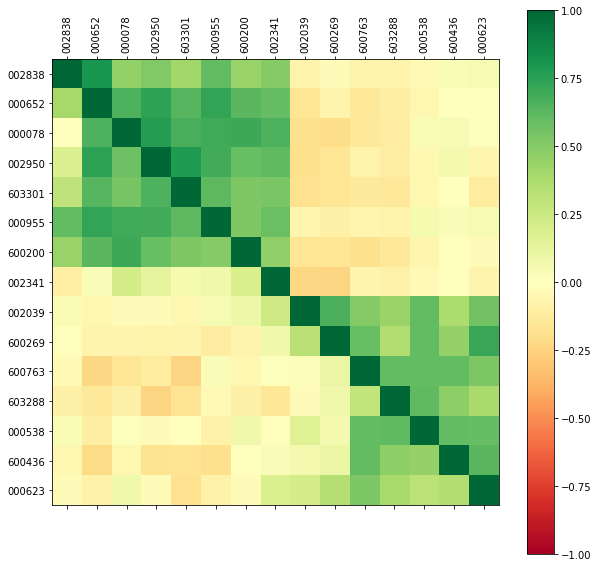

In [82]:
%%time

# Pearson correlation matrix with no clustering
# Pearson correlation matrix for the close price between '2020-01-01' and '2020-06-30'
# Queried with ['000652', '000538'] = ['泰达股份', '云南白药'], and correlation threshold set as 0.6
# Resulted with 11 elements
# plot_corr(community_corr.close)

community_corr = two_phase_hierarchical_clustering(community_corr)

community_index_corr = find_index_corr(community_corr.close.index)
# Two phase hierarchical_clustering result, first base on close price (log return) then trading volume (log trading volume)
# With price as top-right, trading volume as bottom left
plot_corr(combine_corr_matrix(community_corr.close, community_corr.vol))

[{'row': '000955',
  'col': '000955',
  'val': -0.032555210438587286,
  'type': 'market'},
 {'row': '000955', 'col': '600200', 'val': 0.52342, 'type': 'price'},
 {'row': '000955', 'col': '002838', 'val': 0.60876, 'type': 'price'},
 {'row': '000955', 'col': '000078', 'val': 0.70262, 'type': 'price'},
 {'row': '000955', 'col': '002950', 'val': 0.69059, 'type': 'price'},
 {'row': '000955', 'col': '603301', 'val': 0.62196, 'type': 'price'},
 {'row': '000955', 'col': '000652', 'val': 0.73243, 'type': 'price'},
 {'row': '000955', 'col': '002341', 'val': 0.58012, 'type': 'price'},
 {'row': '000955', 'col': '002039', 'val': -0.056, 'type': 'price'},
 {'row': '000955', 'col': '600269', 'val': -0.08879, 'type': 'price'},
 {'row': '000955', 'col': '000538', 'val': 0.05027, 'type': 'price'},
 {'row': '000955', 'col': '600436', 'val': 0.02721, 'type': 'price'},
 {'row': '000955', 'col': '000623', 'val': 0.04192, 'type': 'price'},
 {'row': '000955', 'col': '600763', 'val': -0.05572, 'type': 'price'}

# 4. Correlation of different timeframes

In [16]:
start_date = '2020-01-01'
end_date = '2020-06-30'
# start_date = '2011-01-01'
# end_date = '2020-12-31'
query_code = '000652'
# query_code = '000538'
# query_code = '603301'

display(stock_info_list.query('ts_code == @query_code'))

def plot_corr(df,size=10):    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(df, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(cax)
    plt.gca().xaxis.tick_bottom()
    plt.xticks(range(len(df.columns)), df.columns, rotation=-90);
    plt.yticks(range(len(df.index)), df.index);

def rolling_corr_market(query_code='000652', start_date='2020-01-01', end_date='2020-06-30'):
    # find appropriate window size
    trade_days = trade_cal.query('@start_date <= cal_date <= @end_date')['is_open'].sum()
    window = int(max(1, trade_days/200))
    
    # filter stock price by timeframe
    index_price = index_daily_log[['000001.SH']].loc[start_date:end_date]
    stock_price = stock_daily_log.close[query_code].loc[start_date:end_date]
    index_stock_price = index_price.merge(stock_price, left_index=True, right_index=True)[::window]
    index_price = index_stock_price[index_stock_price.columns[0]]
    stock_price = index_stock_price[index_stock_price.columns[1]]
    
    # find individual corrlation with market
    pinus = {day: index_price.rolling(day, min_periods=1).corr(stock_price) for day in range(len(index_stock_price), 1, -1)}
    pinus = pd.DataFrame(pinus).round(4).replace([np.inf, -np.inf], np.nan)
    pinus.index = pinus.index.strftime('%Y-%m-%d')
    pinus = pinus.drop(index=pinus.index[0]).transpose() # round to 4dp and drop window size 1 because self correlation is always 1
    return pinus

def find_index_code(query_code='000652'):
    industry_code = industry_member_list.query('ts_code == @query_code and level == "L1"').industry_code.to_list()[0]
    return index_industry_list.query('industry_code == @industry_code').iloc[0]

,ts_code,symbol,name,area,industry,market,list_date,exchange,chairman,manager,secretary,reg_capital,setup_date,province,city,website,email,employees
210,000652,652,泰达股份,天津,批发业,主板,1996-11-28,SZSE,张旺,None,杨雪晶,147557.3852,1981-08-20,天津,天津市,www.tedastock.com,dm@tedastock.com,1274.0


In [17]:
%%time
pinus = rolling_corr_market(query_code, start_date, end_date)
pinus

CPU times: user 378 ms, sys: 2.92 ms, total: 381 ms
Wall time: 382 ms


trade_date,2020-01-03,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-22,2020-06-23,2020-06-24,2020-06-29,2020-06-30
117,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0700
116,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0700,-0.0693
115,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0700,-0.0693,-0.0693
114,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0693,-0.0693,-0.0693,-0.0693
113,-1.0,-0.5213,0.1801,0.7499,0.7730,0.7790,0.7722,0.7588,0.7607,0.7773,...,-0.0570,-0.0650,-0.0643,-0.0649,-0.0686,-0.0686,-0.0686,-0.0693,-0.0693,-0.0710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,-1.0,-0.5213,0.1801,0.7499,0.7730,0.9370,0.9154,0.8998,0.9248,0.9084,...,-0.4942,-0.6653,-0.6672,-0.7300,-0.8671,-0.8524,-0.5592,-0.3958,-0.6515,-0.4859
5,-1.0,-0.5213,0.1801,0.7499,0.9416,0.9476,0.9169,0.9469,0.8974,0.8302,...,-0.4033,-0.7027,-0.7969,-0.8479,-0.8632,-0.6415,-0.3942,-0.4384,-0.7848,-0.2352
4,-1.0,-0.5213,0.1801,0.9911,0.9499,0.9477,0.9917,0.8647,0.8345,0.8568,...,-0.4609,-0.8136,-0.9986,-0.8476,-0.5670,-0.4662,-0.4446,-0.6830,-0.7178,-0.1562
3,-1.0,-0.5213,0.9731,0.9922,0.9496,0.9996,0.9576,0.7624,0.9447,0.8174,...,-0.4241,-0.9993,-0.9997,-0.5440,-0.3845,-0.5107,-0.6828,-0.7748,-0.8642,-0.2442


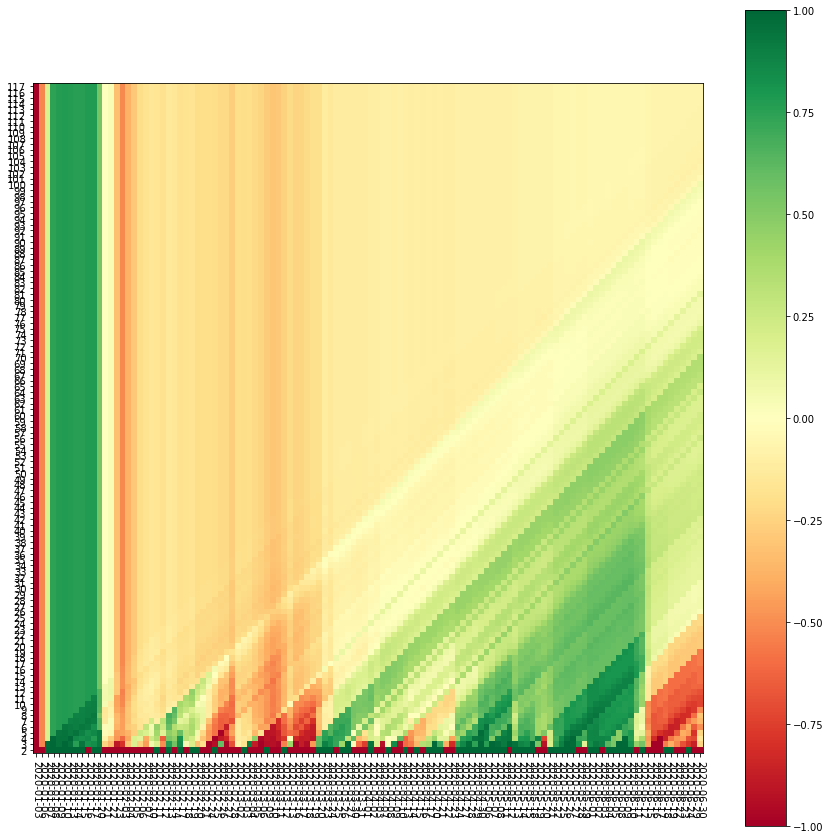

In [18]:
plot_corr(pinus, size=15)

pinus_output = {
    'date': pinus.columns.to_list(),
    'window': pinus.index.to_list(),
    'corr': [i for num, row in pinus.iterrows() for i in row.fillna(2).to_list()[-(len(pinus)+2-num):]]
}
# with open('../../client/src/components/pinus.json', 'w+') as file:
#     simplejson.dump(pinus_output, file, ignore_nan=True)

# pinus_output